# Prototypical Networks Implementation on Indian Sign Language Classification

### Ayush Muralidharan: PES1UG22AM912
### Tejas V Bhat: PES1UG22AM909
### Atharv Revankar: PES1UG22AM920
### Prarthana Kini: PES1UG22AM119

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
from PIL import Image
import os
import random
import shutil
import itertools
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

#### This class loads and processes a custom image dataset for few-shot learning. It prepares image paths, classes, and labels for downstream usage.



In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, split_ratio=0.8):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.split_ratio = split_ratio

        self._prepare_data()

        self.data_dir = os.path.join(root_dir, 'train' if train else 'test')
        print(f"Looking for data in: {self.data_dir}")

        # Dictionary to store images for each class
        class_images = {}
        for cls_folder in os.listdir(self.data_dir):
            cls_folder_path = os.path.join(self.data_dir, cls_folder)
            if os.path.isdir(cls_folder_path):  # Check if it's a class directory
                images = [
                    os.path.join(cls_folder_path, img)
                    for img in os.listdir(cls_folder_path)
                    if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
                ]
                if images:
                    class_images[cls_folder] = images

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_images.keys())}
        self.classes = list(self.class_to_idx.keys())  # <-- Ensure this line is included
        self.image_paths = [(path, self.class_to_idx[cls_name])
                            for cls_name, paths in class_images.items()
                            for path in paths]

        print(f"Found classes: {self.classes}")
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {self.data_dir}. Please check the directory structure.")

    def _prepare_data(self):
        train_dir = os.path.join(self.root_dir, 'train')
        test_dir = os.path.join(self.root_dir, 'test')

        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        if os.path.exists(train_dir) and os.path.exists(test_dir):
            print("Train/test directories already exist. Skipping data preparation.")
            return

        print("Creating train and test splits...")

        class_images = {}
        for cls_folder in os.listdir(self.root_dir):
            cls_folder_path = os.path.join(self.root_dir, cls_folder)
            if os.path.isdir(cls_folder_path):  # Check if it's a class directory
                for sub_folder in os.listdir(cls_folder_path):
                    sub_folder_path = os.path.join(cls_folder_path, sub_folder)
                    if os.path.isdir(sub_folder_path):
                        images = [
                            os.path.join(sub_folder_path, file)
                            for file in os.listdir(sub_folder_path)
                            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
                        ]
                        if images:
                            class_images.setdefault(cls_folder, []).extend(images)

        for cls_name, images in class_images.items():
            random.shuffle(images)
            split_idx = int(len(images) * self.split_ratio)

            train_class_dir = os.path.join(train_dir, cls_name)
            test_class_dir = os.path.join(test_dir, cls_name)

            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for idx, src_path in enumerate(images):
                dest_dir = train_class_dir if idx < split_idx else test_class_dir
                dest_path = os.path.join(dest_dir, os.path.basename(src_path))
                try:
                    shutil.copy2(src_path, dest_path)
                except Exception as e:
                    print(f"Error copying file {src_path} to {dest_path}: {e}")

            print(f"Split {len(images)} images for class {cls_name}")

        print("Data preparation complete.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return self.__getitem__(random.randint(0, len(self) - 1))

#### Define Data Augmentation Transforms

**Purpose**:  
Applies data augmentations to training and testing datasets to improve model generalization.

1. **Train Transform**:
   - Includes augmentations (rotation, cropping, horizontal flip, color jitter) for data variability.
   - Normalizes images.

2. **Test Transform**:
   - Only includes resizing and cropping to ensure consistency during evaluation.
   - Normalizes images.

In [5]:
# Define transforms
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.RandomRotation(15),
    transforms.RandomCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
root_dir = '/content/drive/MyDrive/AOML/AOML_PROJECT/Dataset + Notebooks'


Creating dataloaders for both training and testing.


In [7]:
train_set = CustomImageDataset(root_dir=root_dir, train=True, transform=train_transform)
test_set = CustomImageDataset(root_dir=root_dir, train=False, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Train/test directories already exist. Skipping data preparation.
Looking for data in: /content/drive/MyDrive/AOML/AOML_PROJECT/Dataset + Notebooks/train
Found classes: ['assistance', 'skin', 'pray', 'specific', 'doctor', 'small', 'bad', 'from', 'warn', 'college', 'pain', 'agree', 'which', 'secondary', 'become', 'stand']
Train/test directories already exist. Skipping data preparation.
Looking for data in: /content/drive/MyDrive/AOML/AOML_PROJECT/Dataset + Notebooks/test
Found classes: ['today', 'work', 'afraid', 'you']


In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### PrototypicalNetworks
Defines the Prototypical Network model architecture.

1. **Backbone**:
   - Uses a pre-trained ResNet-18 as the feature extractor.
   - Removes the final fully connected layer for feature embeddings.

2. **Forward Pass**:
   - Computes prototypes (mean embeddings) for each class in the support set.
   - Calculates distances between query embeddings and class prototypes.
   - Returns classification scores (negative distances).


In [9]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model Initialization

**Purpose**:  
Initializes the Prototypical Network.

**Hyperparameters**:
   - N_WAY: Number of classes per task.
   - N_SHOT: Number of support images per class.
   - N_QUERY: Number of query images per class.

**TaskSampler**:
   - Creates tasks by sampling support and query sets for evaluation.
   - Each task contains N_WAY, N_SHOT, and N_QUERY samples.

In [10]:
N_WAY = 2 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [instance[1] for instance in test_set.image_paths]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


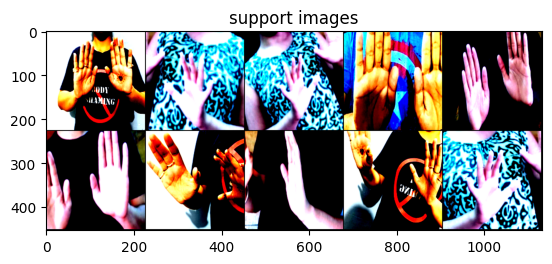

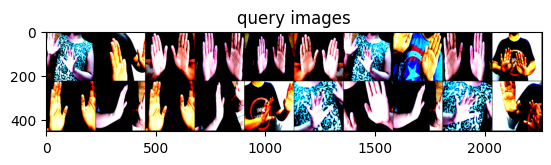

In [11]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [12]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.classes[example_class_ids[example_query_labels[i]]]} / {test_set.classes[example_class_ids[example_predicted_labels[i]]]}"
    )


Ground Truth / Predicted
today / today
today / afraid
today / afraid
today / afraid
today / today
today / afraid
today / today
today / today
today / today
today / afraid
afraid / afraid
afraid / afraid
afraid / afraid
afraid / afraid
afraid / afraid
afraid / today
afraid / afraid
afraid / afraid
afraid / today
afraid / afraid


### Evaluate Model Accuracy

**Purpose**:  
Calculates the accuracy of the Prototypical Network on test tasks.

1. **Evaluate on One Task**:
   - Compares predicted labels with ground truth for a single task.

2. **Evaluate Entire Dataset**:
   - Iterates over all tasks in the test loader and calculates overall accuracy

In [13]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [14]:
N_TRAINING_EPISODES = 1000
N_VALIDATION_TASKS = 500

# train_set.labels = [instance[1] for instance in train_set._flat_character_images]   #incorrect, ignore this line; the following line is correct.
train_set.get_labels = lambda: [instance[1] for instance in train_set.image_paths]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


### Training Procedure

**Purpose**:  
Defines the training process for Prototypical Networks.

1. **Loss Function**:
   - Uses cross-entropy loss for classification.

2. **Optimizer**:
   - Uses Adam optimizer with a learning rate of 0.001.

3. **Training Loop**:
   - For each task, computes the loss, backpropagates, and updates weights.
   - Logs the training loss periodically.


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


In [16]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


100%|██████████| 1000/1000 [08:06<00:00,  2.05it/s, loss=0.28]


In [17]:
# Save the trained model
torch.save(model.state_dict(), "prototypical_network.pth")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
'''model = PrototypicalNetworks(convolutional_network)
model.load_state_dict(torch.load("prototypical_network.pth"))
model = model.cuda()  # if you're using CUDA
'''

'model = PrototypicalNetworks(convolutional_network)\nmodel.load_state_dict(torch.load("prototypical_network.pth"))\nmodel = model.cuda()  # if you\'re using CUDA\n'

In [18]:
evaluate(test_loader)


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]

Model tested on 100 tasks. Accuracy: 81.55%
